In [ ]:
!wget https://huggingface.co/dome272/Paella/resolve/main/paella_v3.pt
!wget https://huggingface.co/dome272/Paella/resolve/main/prior_v1.pt
!wget https://huggingface.co/dome272/Paella/resolve/main/vqgan_f4.pt
!mkdir models
!mv -t models paella_v3.pt prior_v1.pt vqgan_f4.pt

In [ ]:
import os
import time
import torch
import requests
import open_clip
import torchvision
from PIL import Image
from io import BytesIO
from src.vqgan import VQModel
from open_clip import tokenizer
import matplotlib.pyplot as plt
from utils.modules import Paella
from arroz import Diffuzz, PriorModel
from transformers import AutoTokenizer, T5EncoderModel
from utils.alter_attention import replace_attention_layers

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def showimages(imgs, rows=False, **kwargs):
    plt.figure(figsize=(kwargs.get("width", 32), kwargs.get("height", 32)))
    plt.axis("off")
    if rows:
        plt.imshow(torch.cat([torch.cat([i for i in row], dim=-1) for row in imgs], dim=-2).permute(1, 2, 0).cpu())
    else:
        plt.imshow(torch.cat([torch.cat([i for i in imgs], dim=-1)], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

In [5]:
def sample(model, model_inputs, latent_shape, unconditional_inputs=None, init_x=None, steps=12, renoise_steps=None, temperature = (0.7, 0.3), cfg=(8.0, 8.0), mode = 'multinomial', t_start=1.0, t_end=0.0, sampling_conditional_steps=None, sampling_quant_steps=None, attn_weights=None): # 'quant', 'multinomial', 'argmax'
    device = unconditional_inputs["byt5"].device
    if sampling_conditional_steps is None:
        sampling_conditional_steps = steps
    if sampling_quant_steps is None:
        sampling_quant_steps = steps
    if renoise_steps is None:
        renoise_steps = steps-1
    if unconditional_inputs is None:
        unconditional_inputs = {k: torch.zeros_like(v) for k, v in model_inputs.items()}
    intermediate_images = []
    with torch.inference_mode():
        init_noise = torch.randint(0, model.num_labels, size=latent_shape, device=device)
        if init_x != None:
            sampled = init_x
        else:
            sampled = init_noise.clone()
        t_list = torch.linspace(t_start, t_end, steps+1)
        temperatures = torch.linspace(temperature[0], temperature[1], steps)
        cfgs = torch.linspace(cfg[0], cfg[1], steps)
        for i, tv in enumerate(t_list[:steps]):
            if i >= sampling_quant_steps:
                mode = "quant"
            t = torch.ones(latent_shape[0], device=device) * tv

            logits = model(sampled, t, **model_inputs, attn_weights=attn_weights)
            if cfg is not None and i < sampling_conditional_steps:
                logits = logits * cfgs[i] + model(sampled, t, **unconditional_inputs) * (1-cfgs[i])
            scores = logits.div(temperatures[i]).softmax(dim=1)

            if mode == 'argmax':
                sampled = logits.argmax(dim=1)
            elif mode == 'multinomial':
                sampled = scores.permute(0, 2, 3, 1).reshape(-1, logits.size(1))
                sampled = torch.multinomial(sampled, 1)[:, 0].view(logits.size(0), *logits.shape[2:])
            elif mode == 'quant':
                sampled = scores.permute(0, 2, 3, 1) @ vqmodel.vquantizer.codebook.weight.data
                sampled = vqmodel.vquantizer.forward(sampled, dim=-1)[-1]
            else:
                raise Exception(f"Mode '{mode}' not supported, use: 'quant', 'multinomial' or 'argmax'")

            intermediate_images.append(sampled)

            if i < renoise_steps:
                t_next = torch.ones(latent_shape[0], device=device) * t_list[i+1]
                sampled = model.add_noise(sampled, t_next, random_x=init_noise)[0]
                intermediate_images.append(sampled)
    return sampled, intermediate_images

### Loading Models

In [ ]:
model_path = "models"

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(256),
    torchvision.transforms.ToTensor(),
])

def encode(x):
    return vqmodel.encode(x, quantize=True)[2]
    
def decode(img_seq):
    return vqmodel.decode_indices(img_seq)
        
def embed_t5(text, t5_tokenizer, t5_model, device="cuda"):
    t5_tokens = t5_tokenizer(text, padding="longest", return_tensors="pt", max_length=768, truncation=True).input_ids.to(device)
    t5_embeddings = t5_model(input_ids=t5_tokens).last_hidden_state
    return t5_embeddings

vqmodel = VQModel().to(device)
vqmodel.load_state_dict(torch.load(os.path.join(model_path, "vqgan_f4.pt"), map_location=device))
vqmodel.eval().requires_grad_(False)

clip_model, _, _ = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
clip_model = clip_model.to(device).eval().requires_grad_(False)

clip_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
])

t5_tokenizer = AutoTokenizer.from_pretrained("google/byt5-xl")  # change with "t5-b3" for the 10GB model LoL
t5_model = T5EncoderModel.from_pretrained("google/byt5-xl").to(device).requires_grad_(False)

prior_ckpt = torch.load(os.path.join(model_path, "prior_v1.pt"), map_location=device)
prior = PriorModel().to(device)
prior.load_state_dict(prior_ckpt)
prior.eval().requires_grad_(False)
diffuzz = Diffuzz(device=device)
del prior_ckpt

state_dict = torch.load(os.path.join(model_path, "paella_v3.pt"), map_location=device)
model = Paella(byt5_embd=2560).to(device)
model.load_state_dict(state_dict)
model.eval().requires_grad_()
replace_attention_layers(model)
model.to(device)
del state_dict

### Sampling

In [145]:
def load_image(path):
    if path.startswith("http"):
        response = requests.get(path)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(path)
    return preprocess(img).unsqueeze(0).expand(batch_size, -1, -1, -1).to(device)[:, :3]

batch_size = 6
images = [
    load_image("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"),
    # load_image("https://i.pinimg.com/736x/45/f4/d9/45f4d91b246800c7886db6bea84b132d.jpg"),
    # load_image("https://tastesbetterfromscratch.com/wp-content/uploads/2020/04/Paella-7-500x500.jpg"),
    # load_image("https://www.planetware.com/photos-large/F/eiffel-tower.jpg"),
    # load_image("https://images.mansionglobal.com/im-355118?width=619"),
]
for imgs in images:
    showimages(imgs)

CLIP Text Embedding:  0.4558696746826172
Prior Sampling:  0.8537781238555908
Generator Sampling:  5.869468927383423
an image of a shiba inu, donning a spacesuit and helmet, traversing the uncharted terrain of a distant, extraterrestrial world, as a symbol of the intrepid spirit of exploration and the unrelenting curiosity that drives humanity to push beyond the bounds of the known


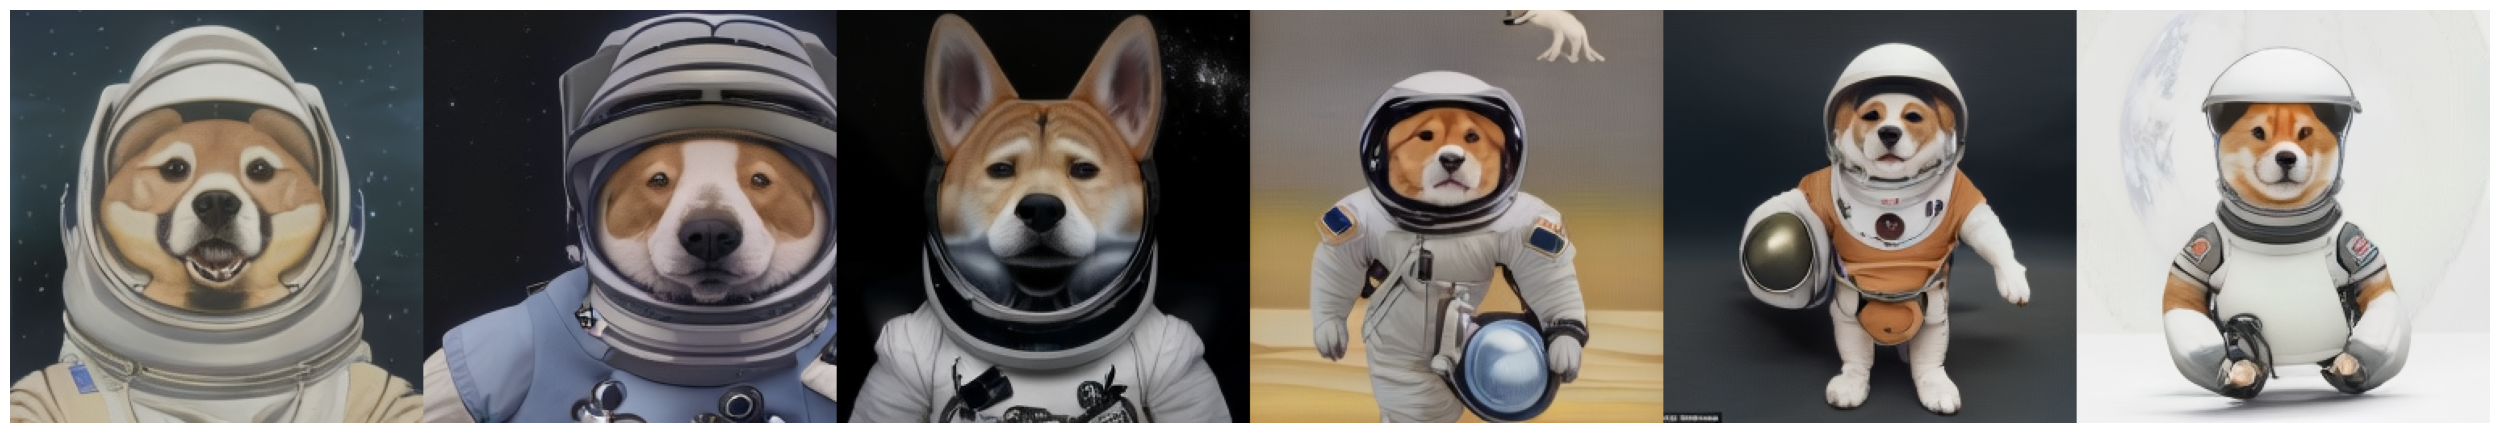

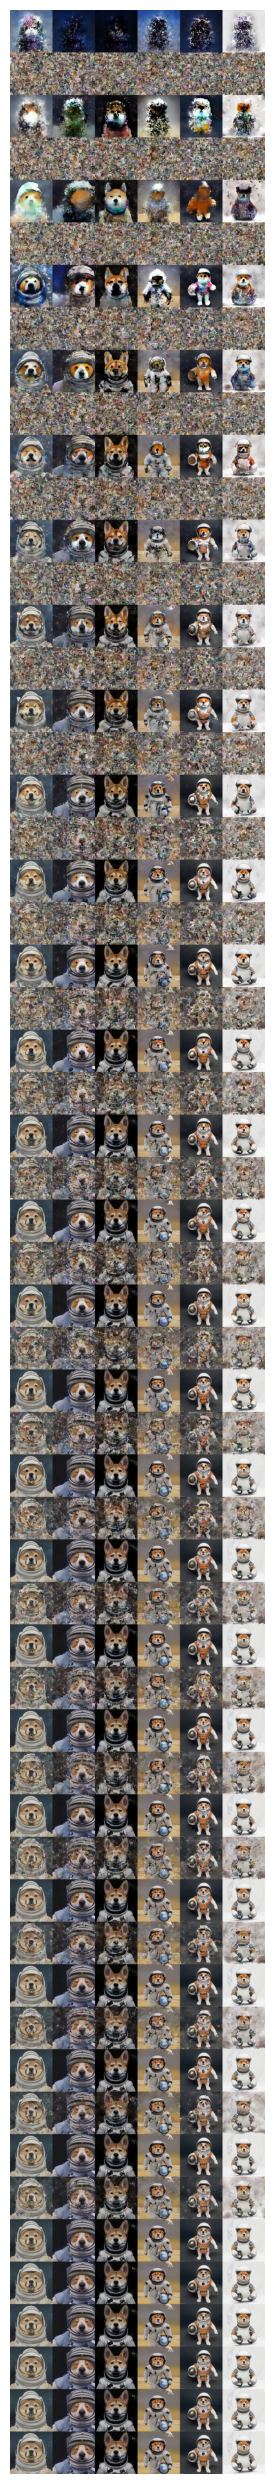

In [150]:
batch_size = 6
caption = "an image of a shiba inu, donning a spacesuit and helmet, traversing the uncharted terrain of a distant, extraterrestrial world, as a symbol of the intrepid spirit of exploration and the unrelenting curiosity that drives humanity to push beyond the bounds of the known"
t5, clip_text, clip_image = True, True, True  # decide which conditionings to use for the sampling
use_prior = True  # whether to use generate clip image embeddings with the prior or to use image embeddings from given images defined in the cell above

negative_caption = "low quality, low resolution, bad image, blurry, blur"
# negative_caption = False
latent_shape = (batch_size, 64, 64)  # latent shape of the generated image, we are using an f4 vqgan and thus sampling 64x64 will result in 256x256

prior_timesteps, prior_cfg, prior_sampler, clip_embedding_shape = 60, 3.0, "ddpm", (latent_shape[0], 1024)

torch.manual_seed(42)
text = tokenizer.tokenize([caption] * latent_shape[0]).to(device)
with torch.inference_mode():
    if negative_caption:
        clip_text_tokens_uncond = tokenizer.tokenize([negative_caption] * len(text)).to(device)
        t5_embeddings_uncond = embed_t5([negative_caption] * len(text), t5_tokenizer, t5_model, device=device)
    else:
        clip_text_tokens_uncond = tokenizer.tokenize([""] * len(text)).to(device)
        t5_embeddings_uncond = embed_t5([""] * len(text), t5_tokenizer, t5_model, device=device)
    if t5:
        t5_embeddings = embed_t5([caption] * latent_shape[0], t5_tokenizer, t5_model, device=device)
    else:
        t5_embeddings = t5_embeddings_uncond
    
    if clip_text:
        s = time.time()
        clip_text_embeddings = clip_model.encode_text(text)
        clip_text_embeddings_uncond = clip_model.encode_text(clip_text_tokens_uncond)
        print("CLIP Text Embedding: ", time.time() - s)
    else:
        clip_text_embeddings = None

    if clip_image:
        if use_prior:
            if not clip_text:
                clip_text_embeddings = clip_model.encode_text(text)
            s = time.time()
            clip_image_embeddings = diffuzz.sample(
                prior, {'c': clip_text_embeddings}, clip_embedding_shape,
                timesteps=prior_timesteps, cfg=prior_cfg, sampler=prior_sampler
            )[-1]
            if not clip_text:
                clip_text_embeddings = None
            print("Prior Sampling: ", time.time() - s)
        else:
            s = time.time()
            clip_image_embeddings = [clip_model.encode_image(clip_preprocess(imgs)).float() for imgs in images]
            print("CLIP Image Embedding: ", time.time() - s)
    else:
        clip_image_embeddings = None
        
    s = time.time()
    attn_weights = torch.ones((t5_embeddings.shape[1]))
    attn_weights[-4:] = 0.4  # reweigh attention weights for image embeddings --> less influence
    attn_weights[:-4] = 1.2  # reweigh attention weights for the rest --> more influence
    attn_weights = attn_weights.to(device)
    
    with torch.autocast(device_type="cuda"):
        sampled_tokens, intermediate = sample(model, model_inputs={'byt5': t5_embeddings, 'clip': clip_text_embeddings, 'clip_image': clip_image_embeddings}, unconditional_inputs={'byt5': t5_embeddings_uncond, 'clip': clip_text_embeddings_uncond, 'clip_image': None},
                                        temperature=(1.2, 0.2), cfg=(8,8), steps=32, renoise_steps=26, latent_shape=latent_shape, t_start=1.0, t_end=0.0,
                                                      mode="multinomial", sampling_conditional_steps=None, attn_weights=attn_weights)
        
    sampled = decode(sampled_tokens)
    print("Generator Sampling: ", time.time() - s)
        
    intermediate = [decode(i) for i in intermediate]

print(caption)
# showimages(images)
# for imgs in images: showimages(imgs)
showimages(sampled.float())
showimages(intermediate, rows=True)